### Eigenvector spatial filtering: California

This file demonstrates how ESF features are incorporated for California dataset.

In [1]:
# setwd("../Results")
options(stringsAsFactors = F)

--------
#### Load the helper functions:

- *meigen_full*: generating eigenvectors (adopted from 'spmoran' package)
- *esf_coeffs*: performing LASSO selection
- *hold_eval*: trainging/testing evaluation    

Please refer to the source file for details of these functions.

In [2]:
source("esf_funcs.R")

In [3]:
# Data ----
library(ggplot2)
library(dplyr)
library(sf)

housing <- read.csv("../Data/houses1990.csv") %>% 
  mutate(bedroomsAvg = bedrooms / households, 
         roomsAvg = rooms / households) %>% 
  select(-c("bedrooms", "rooms"))

# Transform to 'sf' object
housing.sf <- st_as_sf(housing, coords = c("longitude", "latitude"), crs = 4326)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



In [5]:
head(housing.sf)

,houseValue,income,houseAge,population,households,bedroomsAvg,roomsAvg,geometry
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<POINT [°]>
1,452600,8.3252,41,322,126,1.0238095,6.984127,POINT (-122.23 37.88)
2,358500,8.3014,21,2401,1138,0.9718805,6.238137,POINT (-122.22 37.86)
3,352100,7.2574,52,496,177,1.0734463,8.288136,POINT (-122.24 37.85)
4,341300,5.6431,52,558,219,1.0730594,5.817352,POINT (-122.25 37.85)
5,342200,3.8462,52,565,259,1.0810811,6.281853,POINT (-122.25 37.85)
6,269700,4.0368,52,413,193,1.1036269,4.761658,POINT (-122.25 37.85)


#### Spatial CV: train/test splitting

First, the traning and testing folds for spatial CV are generated. Here we use 5 outer folds and 3 inner folds. Package *mlr* requires a resample description object. Then the resampling instace is created based on the task defined.

Note: change the value of variable ***cvmethod*** to "CV" for nornal CV

In [4]:
# Spatial CV: train/test splitting ----

library(mlr)
outer_n <- 5
inner_n <- 3
cvmethod <- "SpCV" # Change to"CV" for normal CV

Loading required package: ParamHelpers

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).



In [5]:
set.seed(123) # Set seeds
# Resampling description (outer folds)
rdesc <- makeResampleDesc(cvmethod, iters = outer_n)
# Regression task definition
spatial.task <- makeRegrTask(data = st_drop_geometry(housing.sf), target = "houseValue", 
                             coordinates = as.data.frame(st_coordinates(housing.sf)))
# Resampling instance (outer folds)
outer.rin <- makeResampleInstance(rdesc, task = spatial.task)
rm(rdesc, spatial.task)

# Generating inner folds
inner <- lapply(1:length(outer.rin$train.inds), function(i) {
  idx.train <- outer.rin$train.inds[[i]]
  idx.test <- outer.rin$test.inds[[i]]
  set.seed(123)
  rdesc <- makeResampleDesc(cvmethod, iters = inner_n)
  spatial.task <- makeRegrTask(data = st_drop_geometry(housing.sf[idx.train,]), target = "houseValue", 
                               coordinates = as.data.frame(st_coordinates(housing.sf[idx.train,])))
  inner.rin <- makeResampleInstance(rdesc, task = spatial.task)
  list(train.inds = inner.rin$train.inds, test.inds = inner.rin$test.inds)
})

The distribution of outer folds:

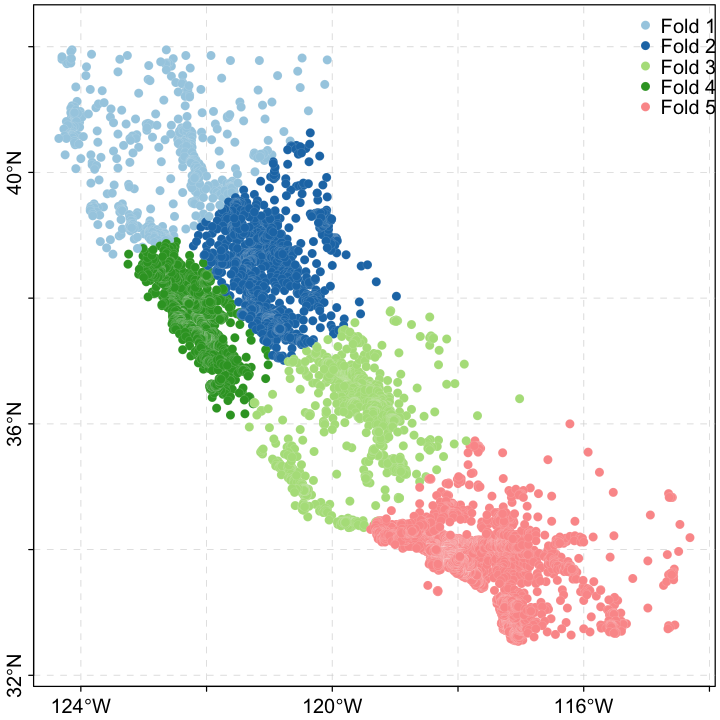

In [10]:
fold <- 5
col <- RColorBrewer::brewer.pal(fold, "Paired")
idx <- rep_len(" ", nrow(housing.sf))
cols <- sapply(1:fold, function(i){
  rep_len(col[i], length.out = length(outer.rin$test.inds[[i]]))
}) %>% unlist()
idx[unlist(outer.rin$test.inds)] <- cols

coords <- st_coordinates(housing.sf) %>% as.data.frame()

library(repr)
# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)

par(mar=c(1.2,1.2,0,0)+0.2, tcl=-0.2)
plot(coords$X, coords$Y, type = 'n', xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1)
ext <- par('usr')
segments(x0=axTicks(1), y0=ext[2],
         x1=axTicks(1), y1=ext[4], lwd=0.5,lty=2,col='lightgrey')
segments(x0=ext[1], y0=axTicks(2),
         x1=ext[3], y1=axTicks(2), lwd=0.5,lty=2,col='lightgrey')
points(coords$X, coords$Y, 
       pch = 21, bg = idx, col = 'white', cex=1, lwd = 0.08)
xlabs <- sapply(-axTicks(1), function(x) as.expression(substitute(l*degree*"W",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = sapply(seq_along(xlabs), function(i) ifelse(i%%2 != 0, xlabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=1)
axis(2, axTicks(2), labels = sapply(seq_along(ylabs), function(i) ifelse(i%%2 != 0, ylabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=1)
legend("topright", legend=paste0("Fold ", 1:5), pch = 21, pt.bg = col, 
       col = 'white', cex = 1, bty = 'n', pt.cex =1, pt.lwd = 0.08)

#### Spatial CV: evaluating

For every outer fold, hyperparameters are tuned on the inner folds. The best hyperparameter setting is used to train on the corresponding outer fold.

Note: the following code may take a long time.

In [6]:
# Spatial CV: evaluation ----
library(glmnet)
library(FNN)
library(ranger)
library(spmoran)
library(foreach)
library(parallel)
library(doParallel)

# Multi-core computing
cl <- makeCluster(detectCores()-1)
registerDoParallel(cl)

res <- lapply(1:outer_n, function(oi) {
  # inner folds eval
  params <- 2:6 # 'mtry' candidates
  ex_pkgs <- c("sf", "spmoran", "ModelMetrics", "caret", "ranger", "dplyr", "glmnet", "mlr")
  vars <- c(ls(), ls(envir = globalenv()))
  res.rmse <- lapply(1:length(params), function(i){
    cv.res <- foreach(cvi = 1:inner_n, .combine = "c", 
                      .packages = ex_pkgs, .export = vars) %dopar%{
                        hold_eval(param = params[i],  
                                  train.id = inner[[oi]]$train.inds[[cvi]], 
                                  test.id = inner[[oi]]$test.inds[[cvi]], 
                                  target.var = "houseValue", data.sf = housing.sf, 
                                  lasso.cv = cvmethod, lasso.fold = 20, 
                                  prox = TRUE, spatial = TRUE)
                      }
    aggregate(unlist(cv.res), by = list(rep(1:4, times = inner_n)), mean)[3, 2]
  })
  print(paste0("Done: inner tuning of outer fold ", oi))
  flush.console()
  # outer eval
  rmse.outer <- unlist(hold_eval(param = params[which.min(res.rmse)],
                                 train.id = outer.rin$train.inds[[oi]], test.id = outer.rin$test.inds[[oi]], 
                                 target.var = "houseValue", data.sf = housing.sf, 
                                 lasso.cv = cvmethod, lasso.fold = 20, 
                                 prox = TRUE, spatial = TRUE))
  print(paste0("Done: outer fold ", oi, ". RMSE: ", rmse.outer[3]))
  flush.console()
  return(rmse.outer)
})
stopCluster(cl)
# Average results from outer folds
avg.nested <- aggregate(unlist(res), by = list(rep(1:4, times = outer_n)), mean)[3, 2]


Loading required package: Matrix

Loaded glmnet 3.0-2


Loading required package: iterators



[1] "Done: inner tuning of outer fold 1"


 200/19951 eigen-pairs are approximated



[1] "Done: outer fold 1. RMSE: 68705.304896794"
[1] "Done: inner tuning of outer fold 2"


 200/18314 eigen-pairs are approximated



[1] "Done: outer fold 2. RMSE: 88940.5915932228"
[1] "Done: inner tuning of outer fold 3"


 199/18869 eigen-pairs are approximated



[1] "Done: outer fold 3. RMSE: 108915.964065231"
[1] "Done: inner tuning of outer fold 4"


 200/15813 eigen-pairs are approximated



[1] "Done: outer fold 4. RMSE: 110953.713773956"
[1] "Done: inner tuning of outer fold 5"


 199/9613 eigen-pairs are approximated



[1] "Done: outer fold 5. RMSE: 95698.0461036827"


The estimated generalization RMSE is:

In [7]:
avg.nested

[1] 94642.72

-----

#### Final lag model: tuning

This step is to tune the hyperparameter (`mtry` in random forest) for our final model. 5-fold spatial CV is still used here.

Note: the following code may take a long time.

In [8]:
# Final model: tuning ----
# 5-fold spatial CV
set.seed(134)
rdesc <- makeResampleDesc(cvmethod, iters = 5)
spatial.task <- makeRegrTask(data = st_drop_geometry(housing.sf), target = "houseValue", 
                             coordinates = as.data.frame(st_coordinates(housing.sf)))
tune.rin <- makeResampleInstance(rdesc, task = spatial.task)
rm(rdesc, spatial.task)

params <- 2:6 # 'mtry' candidates
ex_pkgs <- c("sf", "spmoran", "ModelMetrics", "caret", "ranger", "dplyr", "glmnet", "mlr")

cl <- makeCluster(detectCores()-1)
registerDoParallel(cl)
tune.res <- sapply(1:length(params), function(i) {
  vars <- c(ls(), ls(envir = globalenv()))
  cv.res <- foreach(cvi = 1:outer_n, .combine = "c", 
                    .packages = ex_pkgs, .export = vars) %dopar%{
                      hold_eval(params[i],  
                                train.id = tune.rin$train.inds[[cvi]], 
                                test.id = tune.rin$test.inds[[cvi]], 
                                target.var = "houseValue", data.sf = housing.sf, 
                                lasso.cv = cvmethod, lasso.fold = 20, 
                                prox = TRUE, spatial = TRUE)
                    }
  # Averaging the testing RMSE
  aggregate(unlist(cv.res), by = list(rep(1:4, times = 5)), mean)[3, 2]
})
stopCluster(cl)

Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
“already exporting variable(s): i”
Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
“already exporting variable(s): i”
Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
“already exporting variable(s): i”
Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
“already exporting variable(s): i”
Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
“already exporting variable(s): i”


The best 'mtry' value is:

In [9]:
params[which.min(tune.res)]

[1] 6

#### Final lag model: training

Use the best hyperparameter found in last step.

In [10]:
set.seed(567)
train.esfs <- meigen_f(as.matrix(st_coordinates(housing.sf)))
esf.coef <- esf_coeffs(train.esfs$sf, housing.sf$houseValue, 
                       as.data.frame(st_coordinates(housing.sf)), 
                       folds = 20, cvmethod = cvmethod)
esfsub <- as.data.frame(train.esfs$sf)[, esf.coef != 0, drop=FALSE]
# Combine the original features with esf eigenvectors

housing.final <- dplyr::bind_cols(housing.sf, esfsub)

# Use the parameter setting with the lowest RMSE
set.seed(234)
final.model <- ranger::ranger(x = dplyr::select(st_drop_geometry(housing.final), -c("houseValue")), 
                              y = housing.final$houseValue, 
                              mtry = params[which.min(tune.res)], num.trees = 200, num.threads = 2)

pred <- predict(final.model, dplyr::select(st_drop_geometry(housing.final), -c("houseValue"))) %>% ranger::predictions()
rmse.train <- ModelMetrics::rmse(actual = housing.final$houseValue, predicted = pred)


 200/20640 eigen-pairs are approximated



Training RMSE of the final model is: .     

In [11]:
rmse.train

[1] 20825.5

The following step evaluates the global spatial autocorrelation (Moran's I) of the residuals. Spatial weight matrix is set to 5 nearest neighbors.

In [12]:
# Final model: Moran ----
library(spdep)
# Creating neighboring list
nb <- FNN::get.knn(as.matrix(st_coordinates(housing.sf)), 5)$nn.index %>% 
  apply(1, list) %>% unlist(recursive = F)
attr(nb, "class") <- "nb"
# Moran's I (1000 Monte-Carlo simulation)
mc <- moran.mc(housing.sf$houseValue - pred, nb2listw(nb), nsim = 999)

Loading required package: sp

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



In [13]:
mc


	Monte-Carlo simulation of Moran I

data:  housing.sf$houseValue - pred 
weights: nb2listw(nb)  
number of simulations + 1: 1000 

statistic = 0.018799, observed rank = 1, p-value = 0.999
alternative hypothesis: greater


-----

The distribution of residuals:

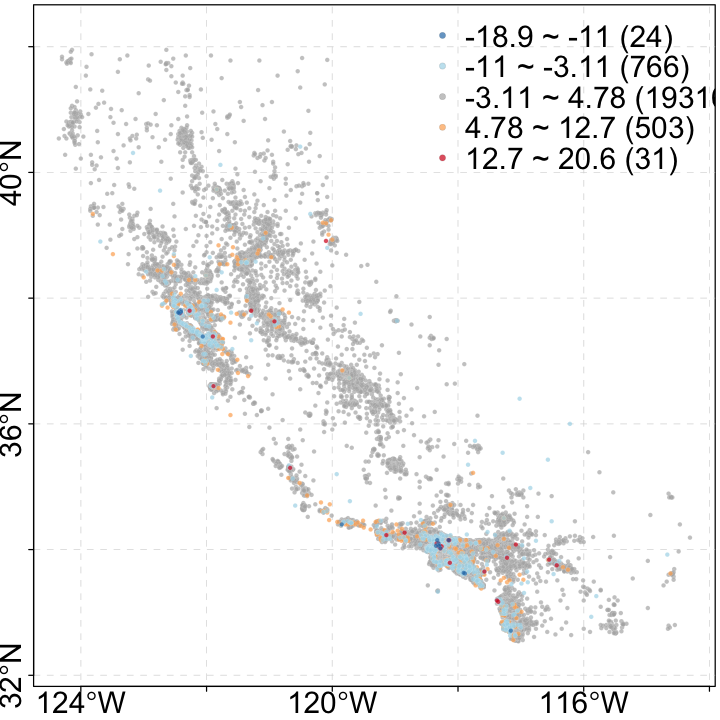

In [14]:
resi <- housing.sf$houseValue - pred
coords <- st_coordinates(housing.sf) %>% as.data.frame()
ngroup <- 5
# intervals <- cut(resi, quantile(resi, seq(0, 1, 1/ngroup))) # quantile break
intervals <- cut(resi, ngroup) # equal interval break
colors <- RColorBrewer::brewer.pal(ngroup, "RdYlBu") %>% scales::alpha(0.7) %>% rev()
colors[3] <- scales::alpha("grey70", 0.7)
legend.lab <- strsplit(levels(intervals), split = "[,(\\]]", perl = T) %>% 
  lapply(function(x) {paste(as.numeric(x[-1])/10000, collapse = ' ~ ')}) %>% unlist()
legend.lab <- paste(legend.lab, "(") %>% paste0(table(intervals), ")")


# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)
par(mar=c(1.2,1.2,0,0)+0.2, tcl=-0.2)
plot(coords$X, coords$Y, type = 'n', xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1)
ext <- par('usr')
segments(x0=axTicks(1), y0=ext[2],
         x1=axTicks(1), y1=ext[4], lwd=0.5,lty=2,col='lightgrey')
segments(x0=ext[1], y0=axTicks(2),
         x1=ext[3], y1=axTicks(2), lwd=0.5,lty=2,col='lightgrey')
for(i in c(3,4,2,5,1)){
  points(coords$X[as.numeric(intervals) == i], 
         coords$Y[as.numeric(intervals) == i], 
         pch = 21, bg = colors[intervals][as.numeric(intervals) == i], 
         col = 'white', lwd=0.08, cex=0.5)
}
xlabs <- sapply(-axTicks(1), function(x) as.expression(substitute(l*degree*"W",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = sapply(seq_along(xlabs), function(i) ifelse(i%%2 != 0, xlabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=1.5)
axis(2, axTicks(2), labels = sapply(seq_along(ylabs), function(i) ifelse(i%%2 != 0, ylabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=1.5)
legend("topright", legend = legend.lab, 
       pch = 21, pt.bg = colors, 
       col = 'grey10', cex = 1.5, bty = 'n', pt.cex =0.7, pt.lwd = 0.08)

The distribution of predicted values:

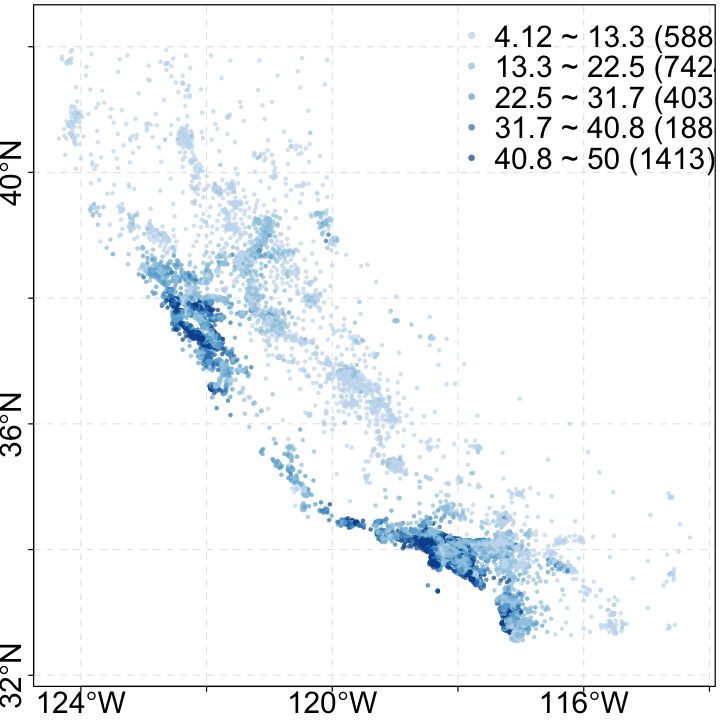

In [15]:
coords <- st_coordinates(housing.sf) %>% as.data.frame()
ngroup <- 5
intervals <- cut(pred, ngroup) # equal interval break
# intervals <- cut(pred, quantile(pred, seq(0, 1, 1/ngroup)), include.lowest = T) 
colors <- RColorBrewer::brewer.pal(ngroup+1, "Blues") %>% 
  scales::alpha(0.7) %>% "["(-1)
legend.lab <- strsplit(levels(intervals), split = "[\\[,(\\]]", perl = T) %>% 
  lapply(function(x) {paste(as.numeric(x[-1])/10000, collapse = ' ~ ')}) %>% unlist()
legend.lab <- paste(legend.lab, "(") %>% paste0(table(intervals), ")")

# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)
par(mar=c(1.2,1.2,0,0)+0.2, tcl=-0.2)
plot(coords$X, coords$Y, type = 'n', xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1)
ext <- par('usr')
segments(x0=axTicks(1), y0=ext[2],
         x1=axTicks(1), y1=ext[4], lwd=0.5,lty=2,col='lightgrey')
segments(x0=ext[1], y0=axTicks(2),
         x1=ext[3], y1=axTicks(2), lwd=0.5,lty=2,col='lightgrey')
points(coords$X, coords$Y, 
       pch = 21, bg = colors[intervals], col = NULL, cex=0.5)
xlabs <- sapply(-axTicks(1), function(x) as.expression(substitute(l*degree*"W",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = sapply(seq_along(xlabs), function(i) ifelse(i%%2 != 0, xlabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=1.5)
axis(2, axTicks(2), labels = sapply(seq_along(ylabs), function(i) ifelse(i%%2 != 0, ylabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=1.5)
legend("topright", legend = legend.lab, 
       pch = 21, pt.bg = colors, 
       col = 'grey10', cex = 1.5, bty = 'n', pt.cex =0.7, pt.lwd = 0.08)

LISA clusters:

Note: The local Moran is calculated from Python library 'PySAL'. Because the PySAL library has dependencies on other spatial packages, the following code may not work on different environments. One possible solution for MacOS users it to change the environment variable *'DYLD_FALLBACK_LIBRARY_PATH'*.

In [ ]:
# Please change the environment variable with caution!
oldenvir <- Sys.getenv("DYLD_FALLBACK_LIBRARY_PATH")
newenvir <- paste(oldenvir, ':/usr/local/lib:/usr/lib', sep='')
Sys.setenv(DYLD_FALLBACK_LIBRARY_PATH = newenvir)

In [ ]:
# Calculate local Moran from Python library 'PySAL'
library(reticulate)
# Specify the Python location
use_python("/usr/local/bin/python3") 
wpysal <- import("libpysal.weights")
esda_Moran <- import("esda.moran")

In [ ]:
multi_lag <- function(x) {0}
insertSource("lag_funcs.R", functions = "multi_lag")
multi_lag <- multi_lag@.Data

resi <- housing.sf$houseValue - pred

nb_pysal <- unclass(nb)
names(nb_pysal) <- seq_along(nb)
local.m.pysal <- esda_Moran$Moran_Local(resi, wpysal$W(dict(nb_pysal)))
local.m.i <- local.m.pysal$Is
local.p <- local.m.pysal$p_sim 

lag.resi <- multi_lag(resi, as.matrix(st_coordinates(housing.sf)), 
                      k.vec = c(5)) %>% simplify2array()
lisa_lable <- function(x, lag, localP){
  mean.x <- mean(x)
  mean.lag <- mean(lag)
  labels <- sapply(seq_along(x), function(i){
    if((x[i] >= mean.x & lag[i] >= mean.lag) & (localP[i] <= 0.05))
      return(1) # high-high
    if((x[i] < mean.x & lag[i] < mean.lag) & (localP[i] <= 0.05))
      return(2) # low-low
    if((x[i] >= mean.x & lag[i] < mean.lag) & (localP[i] <= 0.05))
      return(3) # high-low
    if((x[i] < mean.x & lag[i] >= mean.lag) & (localP[i] <= 0.05))
      return(4) # low-high
    if(localP[i] > 0.05)
      return(5) # non-significant
  })
  return(factor(labels, levels = 1:5))
}
lab <- lisa_lable(resi, lag.resi, local.p)
table(lab)
rm(local.m.pysal)

colors <- c("red", "blue", "lightpink", "skyblue2", "grey80") %>% 
  scales::alpha(0.7)
coords <- st_coordinates(housing.sf) %>% as.data.frame()


# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)
par(mar=c(1.2,1.2,0,0)+0.2, tcl=-0.2)
plot(coords$X[which(lab == 5)], coords$Y[which(lab == 5)], 
     pch = 21, bg = colors[5], col = NULL, xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1, cex=0.5)
grid(NULL, NULL)
xlabs <- sapply(-axTicks(1), function(x) as.expression(substitute(l*degree*"W",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = sapply(seq_along(xlabs), function(i) ifelse(i%%2 != 0, xlabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=8/12)
axis(2, axTicks(2), labels = sapply(seq_along(ylabs), function(i) ifelse(i%%2 != 0, ylabs[i], "")), 
     mgp = c(2,0.3,0), cex.axis=8/12)

for(i in 1:4){
  points(coords$X[which(lab == i)], coords$Y[which(lab == i)], 
         pch = 21, bg = colors[lab][which(lab == i)], col = 'grey20', lwd = 0.2, cex=0.5)
}
legend("topright", legend = paste(c("High-High (", "Low-Low (", "High-Low (", 
                                   "Low-High (", "Not Signif. ("), table(lab), ")", sep = ''), 
       pch = 21, pt.bg = colors, 
       col = 'white', cex = 8/12, bty = 'n', pt.cex =0.7, pt.lwd = 0.08)